# Training a Bayesian Neural Network for Computer Model Emulation

### Import necessary libraries 

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [2]:
# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [3]:
from calculations_load import *
from configurations import *

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [4]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [5]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
feature_cols = ['norm', 'trento_p'] #specific choices
#feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)
obs = 'dNch_deta' #choose the observable we want to emulate

#n_cent = 1 # choose the number of centrality bins 

cent = 5 # choose the cent bin 
Y = []
for pt in range(npt):
    Y.append( trimmed_model_data[system_str][pt, idf][obs]['mean'][cent:cent+1] )

Y = np.array(Y)

In [6]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 2)
Y.shape : (485, 1)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [7]:
X = X.astype(floatX)
Y = Y.astype(floatX)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(Y_train)
#X_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
#Y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

In [8]:
#NECESSARY IF Y HAS A SINGLE FEATURE
Y_train_sc = Y_train_sc.reshape(Y_train_sc.shape[0])
Y_test_sc = Y_test_sc.reshape(Y_test_sc.shape[0])

### Plot a feature matrix of how our inputs correlate with outputs

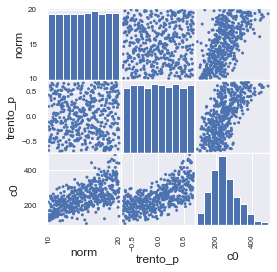

In [9]:
#df_Y = pd.DataFrame(data=Y, columns=["c0", "c1", "c2", "c3"])
df_X = pd.DataFrame(data=X[feature_cols].values, columns=feature_cols) #need to line up the rows (missing data)
df_Y = pd.DataFrame(data=Y, columns=["c0"])
df_X_Y = df_X.join(df_Y) 
scatter_matrix(df_X_Y, figsize = (2*n_features,2*n_features), alpha=1)
plt.show()

### The cell below constructs the Bayesian neural network
I'm not sure yet how to best choose the priors for the weights - overfitting should probably be a primary concern

In [10]:
sigma_w = 1 #how should we fix this prior ???
sigma_pred = 1.0 #how should we fix this prior ???

#whether the non-linear activation functions are turned on ...
build_linear_net = False

def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
    # Initialize random biases in each layer
    init_b_1 = np.random.randn(n_hidden).astype(floatX)
    init_b_2 = np.random.randn(n_hidden).astype(floatX)
    init_b_out = np.random.randn(1).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train_sc)
        ann_output = pm.Data('ann_output', Y_train_sc)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', mu=0, sigma=sigma_w, shape=(X.shape[1], n_hidden), testval=init_1)
        # Bias at 1st hidden layer
        bias_1 = pm.Normal('b_1', mu=0, sigma=sigma_w, shape=(n_hidden), testval=init_b_1)

        # Weights from 1st hidden to 2nd hidden layer
        weights_1_2 = pm.Normal('w_1_2', mu=0, sigma=sigma_w, shape=(n_hidden, n_hidden), testval=init_2)
        # Bias at 2nd hidden layer
        bias_2 = pm.Normal('b_2', mu=0, sigma=sigma_w, shape=(n_hidden), testval=init_b_2)
        
        # Weights from 2nd hidden layer to output
        weights_2_out = pm.Normal('w_2_out', mu=0, sigma=sigma_w, shape=(n_hidden,), testval=init_out)
        # Bias at output hidden layer
        bias_out = pm.Normal('b_out', mu=0, sigma=sigma_w, shape=(1), testval=init_b_out)
        
        if build_linear_net:
            act_1 = pm.math.dot(ann_input, weights_in_1) + bias_1
            act_2 = pm.math.dot(act_1, weights_1_2) + bias_2
            act_out = pm.math.dot(act_2, weights_2_out) + bias_out
        
        else:
            # Build neural-network using tanh activation function
            act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + bias_1)
            act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + bias_2)
            act_out = pm.math.dot(act_2, weights_2_out) + bias_out
            
        
        #try different likelihood functions for fitting
        out = pm.Normal('out', mu=act_out, sigma=sigma_pred, observed=ann_output)
        #out = pm.Cauchy('out', alpha=act_out, beta=sigma_pred, observed=ann_output)
        
    return neural_network

neural_network = construct_nn(X_train_sc, Y_train_sc)

In [11]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

### The cell below uses ADVI to train the network weights

In [12]:
%%time

with neural_network:
    #inference = pm.ADVI() #mean field, no correlations 
    method = 'fullrank_advi' #includes correlation terms in trial functions
    approx = pm.fit(n=50000, method=method)

Average Loss = 444.01: 100%|██████████| 50000/50000 [01:10<00:00, 708.45it/s]
Finished [100%]: Average Loss = 444.01


CPU times: user 1min 37s, sys: 6.6 s, total: 1min 43s
Wall time: 1min 21s


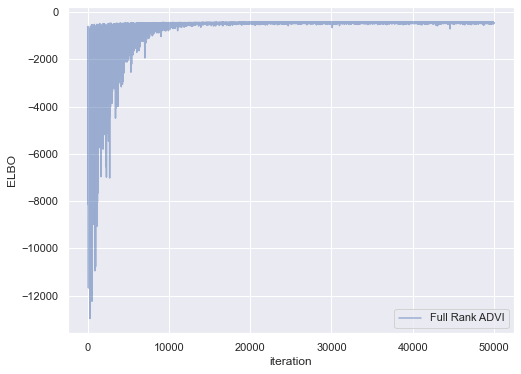

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(-approx.hist, label='Full Rank ADVI', alpha=.5)
ax.legend()
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration')
plt.tight_layout;

### Trace Plot of Inference

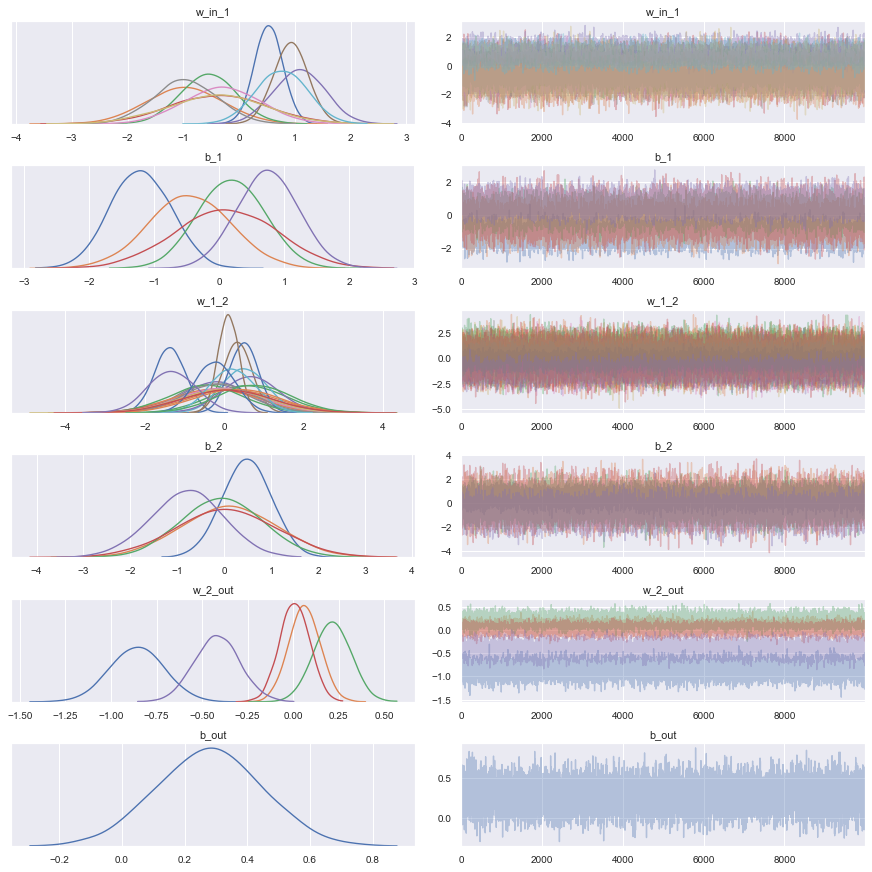

In [14]:
trace = approx.sample(draws=10000)
pm.traceplot(trace)
plt.show()

### Let's ask the network to generate predictions on a grid

In [15]:
x1_grid = np.linspace(-2, 2, 100)
x2_grid = np.zeros((100, n_features-1))
X_grid = np.column_stack((x1_grid, x2_grid))

with neural_network:
    pm.set_data({'ann_input': X_grid})
    pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:12<00:00, 77.67it/s]


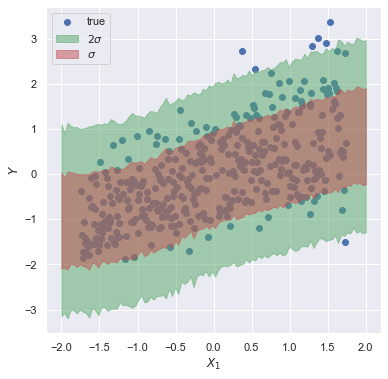

In [16]:
pred_mean = pred['out'].mean(axis=0)
pred_std  = pred['out'].std(axis=0)

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(x=X_train_sc[:, 0], y=Y_train_sc, label='true')
plt.fill_between(x1_grid, pred_mean - 2.*pred_std, pred_mean + 2.*pred_std, 
                 label=r'$2\sigma$', color='g', alpha=0.5)
plt.fill_between(x1_grid, pred_mean - pred_std, pred_mean + pred_std, 
                 label=r'$\sigma$', color='r', alpha=0.5)
plt.legend()
plt.xlabel(r"$X_1$")
plt.ylabel(r"$Y$")
plt.show()

### Check if the network predicts accurately the testing set

In [17]:
with neural_network:
    pm.set_data({'ann_input': X_test_sc})
    pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:12<00:00, 77.96it/s]


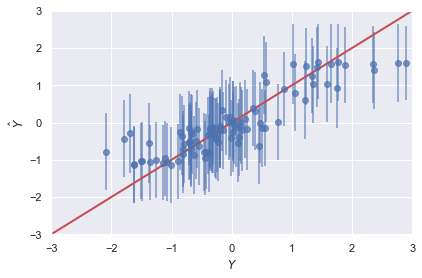

In [18]:
truth_line = np.linspace(-3, 3)
plt.plot(truth_line, truth_line, c='r', lw=2)
pred_mean = pred['out'].mean(axis=0)
pred_std  = pred['out'].std(axis=0)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.errorbar(Y_test_sc, pred_mean, pred_std, ls='None', marker='o', alpha=0.7)
plt.xlabel(r'$Y$')
plt.ylabel(r'$\hat{Y}$')
plt.tight_layout(True)
plt.show()

In [ ]:
#note settings controlled by configurations.py
print("validation = " + str(validation))

In [ ]:
design_v_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat'
design_v = pd.read_csv(design_v_file)
design_v = design_v.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_validation_set)
design_v = design_v.drop(drop_indices)

X_v = design_v[feature_cols]

n_v = SystemsInfo["Pb-Pb-2760"]["n_validation"]
npt_v = n_v - len(delete_design_pts_validation_set)

Y_v = []
for pt in range(npt_v):
    Y_v.append( validation_data[system_str][pt, idf][obs]['mean'][cent:cent+1] )

Y_v = np.array(Y_v)

#REMEMBER TO SCALE THE DATA
X_v_sc = X_scaler.transform(X_v)
Y_v_sc = Y_scaler.transform(Y_v)

In [ ]:
print( "X_v_sc.shape : "+ str(X_v_sc.shape) )
print( "Y_v_sc.shape : "+ str(Y_v_sc.shape) )

## Acknowledgements

This notebook is very much inspired by a blog post written by Thomas Wiecki (and updated by Maxim Kochurov). The
original posts are available [here](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) and [here](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html).

This example uses the [PyMC3](https://docs.pymc.io/) package for probabilistic programming, and relies in particular on the [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi) implementation by [Taku Yoshioka](https://github.com/taku-y).